# **LOAD AND CLEAN THE DATA SET**

In [ ]:
import pandas as pd
import numpy as np

# Load Excel file and Sheet
file_path = '/content/EastWestAirlines.xlsx'
data = pd.read_excel(file_path, sheet_name='data')
data.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


  CHECK FOR MISSING VALUES

In [ ]:
data.isnull().sum()

,0
ID#,0
Balance,0
Qual_miles,0
cc1_miles,0
cc2_miles,0
cc3_miles,0
Bonus_miles,0
Bonus_trans,0
Flight_miles_12mo,0
Flight_trans_12,0


REMOVE OUTLIERS WITH IQR

In [ ]:
def detect_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

outliers = detect_outliers(data.select_dtypes(include=[np.number]))
data_no_outliers = data[~outliers.any(axis=1)]

# To see the shape of the original vs cleaned data:
print("Original shape:", data.shape)
print("Shape after removing outliers:", data_no_outliers.shape)

# To see how many outliers were detected:
print("Number of outliers per column:")
print(outliers.sum())

# Or just preview cleaned data
data_no_outliers.head()



Original shape: (3999, 12)
Shape after removing outliers: (2875, 12)
Number of outliers per column:
ID#                    0
Balance              266
Qual_miles           226
cc1_miles              0
cc2_miles             43
cc3_miles             18
Bonus_miles          280
Bonus_trans           63
Flight_miles_12mo    569
Flight_trans_12      565
Days_since_enroll      0
Award?                 0
dtype: int64


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
5,6,16420,0,1,1,1,0,0,0,0,6942,0


SCALE THE DATA

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_no_outliers.drop(columns=['ID#', 'Award?']))

# To preview the scaled data as a DataFrame:
pd.DataFrame(scaled_data, columns=data_no_outliers.drop(columns=['ID#', 'Award?']).columns).head()

# Or simply check the shape:
print("Scaled data shape:", scaled_data.shape)


Scaled data shape: (2875, 10)


# **CLUSTERING ALGORITHMS**

K-MEANS + ELBOW METHOD

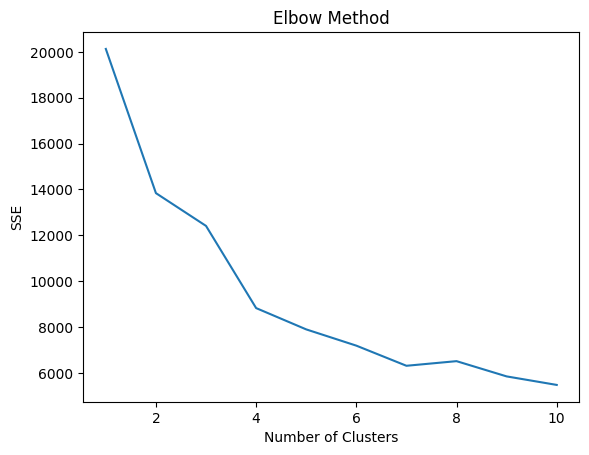

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# Fit final KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(scaled_data)


HIERARCHICAL CLUSTERING

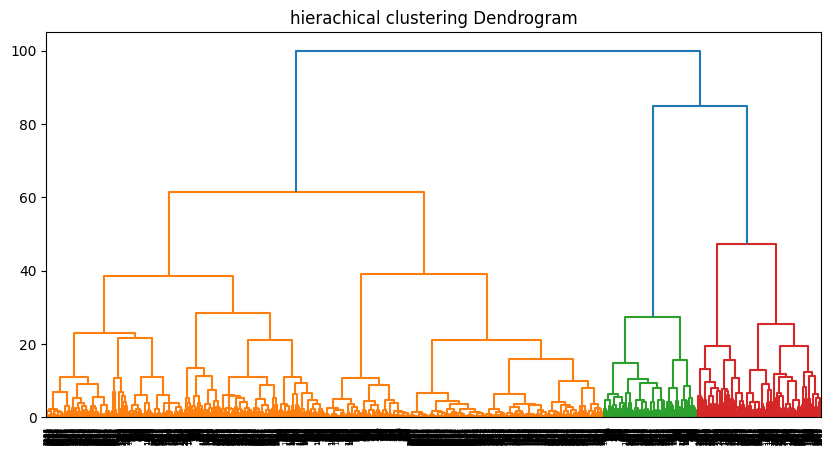

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

linked = linkage(scaled_data, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title('hierachical clustering Dendrogram')
plt.show()

hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters_hc = hc.fit_predict(scaled_data)

DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(scaled_data)

# See the unique cluster labels
print("Unique cluster labels:", np.unique(clusters_dbscan))

# Count how many points per cluster
from collections import Counter
print("Cluster counts:", Counter(clusters_dbscan))

# Add the cluster labels to your original (cleaned, scaled) DataFrame
clustered_df = data_no_outliers.copy()
clustered_df['DBSCAN_Cluster'] = clusters_dbscan
clustered_df.head()


Unique cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Cluster counts: Counter({np.int64(0): 1373, np.int64(-1): 938, np.int64(1): 300, np.int64(2): 122, np.int64(4): 68, np.int64(5): 18, np.int64(10): 13, np.int64(11): 8, np.int64(9): 7, np.int64(7): 6, np.int64(3): 5, np.int64(6): 5, np.int64(12): 5, np.int64(13): 4, np.int64(8): 3})


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?,DBSCAN_Cluster
0,1,28143,0,1,1,1,174,1,0,0,7000,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,0
5,6,16420,0,1,1,1,0,0,0,0,6942,0,0


# **VISUALIZATION**

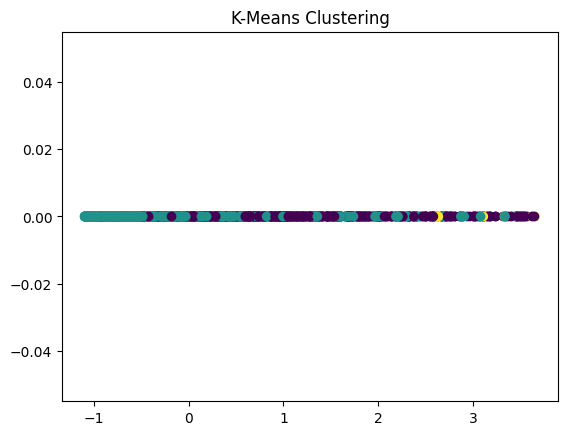

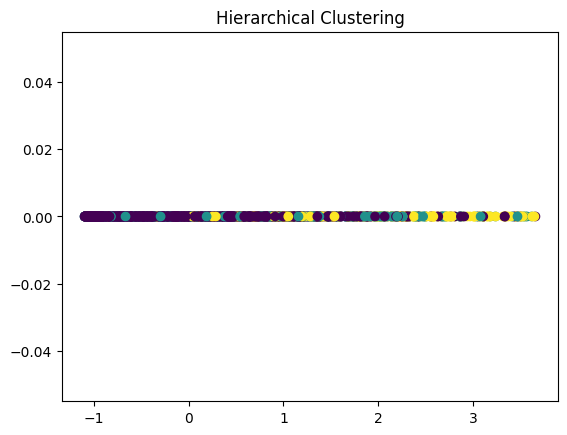

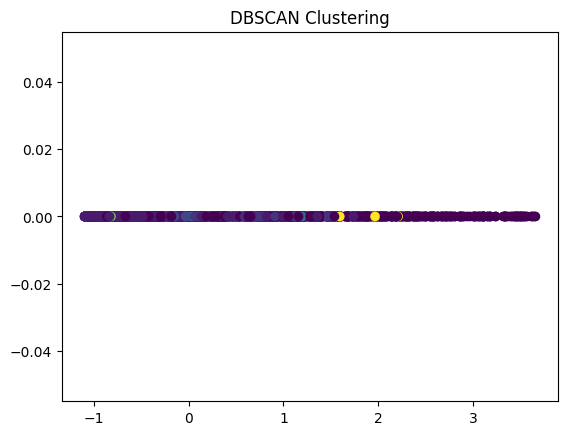

In [ ]:
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=clusters_kmeans)
plt.title('K-Means Clustering')
plt.show()

plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=clusters_hc)
plt.title('Hierarchical Clustering')
plt.show()

plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=clusters_dbscan)
plt.title('DBSCAN Clustering')
plt.show()


# **EVALUATION**

In [ ]:
from sklearn.metrics import silhouette_score

print("Silhouette Score for K-Means:", silhouette_score(scaled_data, clusters_kmeans))
print("Silhouette Score for Hierarchical:", silhouette_score(scaled_data, clusters_hc))
print("Silhouette Score for DBSCAN:", silhouette_score(scaled_data, clusters_dbscan))


Silhouette Score for K-Means: 0.21604887579680404
Silhouette Score for Hierarchical: 0.36393946927160065
Silhouette Score for DBSCAN: -0.17309380825046705


# **PCA FOR BETTER VISUALIZATION**

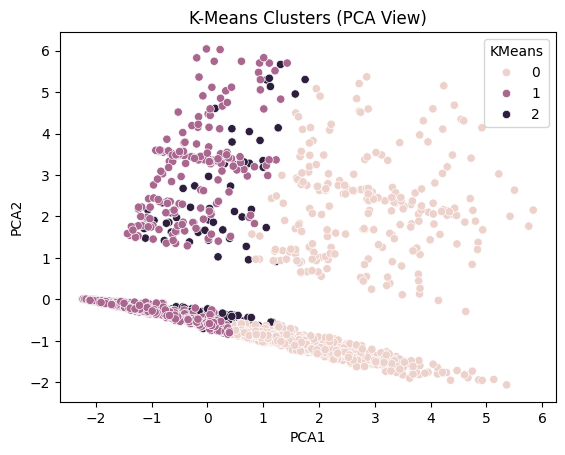

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

df_viz = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_viz['KMeans'] = clusters_kmeans

sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans', data=df_viz)
plt.title('K-Means Clusters (PCA View)')
plt.show()
